<a href="https://colab.research.google.com/github/ethanrangel/football_data_analytics/blob/main/web_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using 'requests' library to make HTTP requests such as GET, POST, PUT, DELETE, ect. In this instance we will just be using 'get'.

In [1]:
import requests

Storing the URL we are going to start scrappping into varible called 'standings_url'

In [2]:
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

Dowloading the html of the page, using 'get' from requests.
Finally storing it in a variable called 'data'.



In [3]:
data = requests.get(standings_url)

Using 'BeautifulSoup' library to parse the html.


In [5]:
from bs4 import BeautifulSoup

Intializing the Soup object

In [6]:
soup = BeautifulSoup(data.text)

Selecting the 'table' tag in the class 'stats_table'. Storing the html for the table in 'standings_table'.

In [7]:
standings_table = soup.select('table.stats_table')[0]

Finding all the 'a' tags inside of 'standings_table' HTML. Storing it in the variable called 'links'. We used 'find_all' becuase its specific for tags but we could also use 'select' like the previous line.

In [9]:
links = standings_table.find_all('a')

Going through each of the 'a' elements and finding the value 'href' property, finally storing it in the varible called 'links'

In [10]:
links = [l.get('href') for l in links]

Filtering the links so we only have squad links. We do this by checking of '/squads/' is in the link.

Now 'links' will hold the following:


```
['/en/squads/b8fd03ef/2023-2024/Manchester-City-Stats',
 '/en/squads/18bb7c10/2023-2024/Arsenal-Stats',
 ...]
```



In [11]:
links = [l for l in links if '/squads/' in l]

Adding the full domain to the partial URLs. Storing the useable absolute links in 'team_urls'

In [13]:
team_urls = [f"https://fbref.com{l}" for l in links]

Getting a single team URL to work with. In this instance we use the first URL in the list which is Machester City



```
['https://fbref.com/en/squads/b8fd03ef/2023-2024/Manchester-City-Stats']
```



In [15]:
mancity = team_urls[0]

Using request 'get' like we did previoulsy but this time for the URL of Manchester City stats.

In [17]:
data = requests.get(mancity)

Using 'Pandas' library to take a table and turn it into a dataframe. In this instance we:


1.    Use 'read_html'  to read all 'table' tags on page.
2.   Use 'match' to grab the Table contains a string of 'Scores & Fixtures'.
3. Finally store it in a varible called 'matches'.
4. We used [0] to take the first element of the list

'matches' will then conatin a DataFrame that will have the first few rows that will look like this:

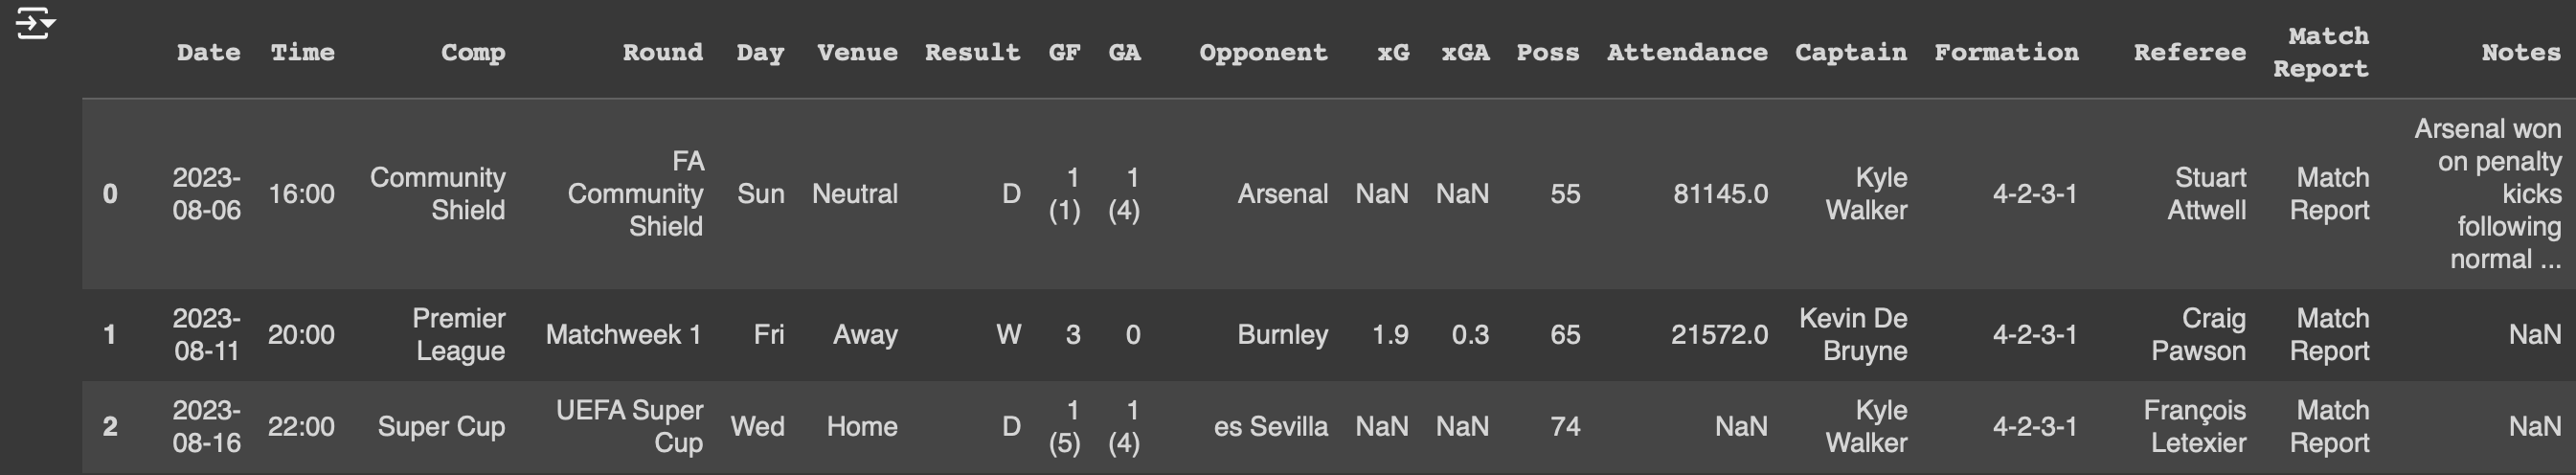

In [19]:
import pandas as pd

matches = pd.read_html(data.text, match="Scores & Fixtures")[0]

We will now complete a similar process of finding Shooting table for manchester city.


1.   First we intialize a Soup object.
2.   Find all links on the page using the 'a' tag.
3. Use "href" to get the actual URL of the link.
4. Filter the link to only find the one with Shooting stats if href exist because some of them dont have one. We also include [0] because the link is mentioned more than once so it returns a list.
5. Finally use 'get' to download the HTML of the link into 'data' variable.



In [35]:
soup = BeautifulSoup(data.text)

links = soup.find_all('a')
links = [l.get('href') for l in links]
links = [l for l in links if l and 'all_comps/shooting' in l][0]

data = requests.get(links)

Once again we will use 'read_html' to read the shooting stats by matching on 'Shooting'.

The 'shooting' variable will then contain a pandas DataFrame that will look like this:

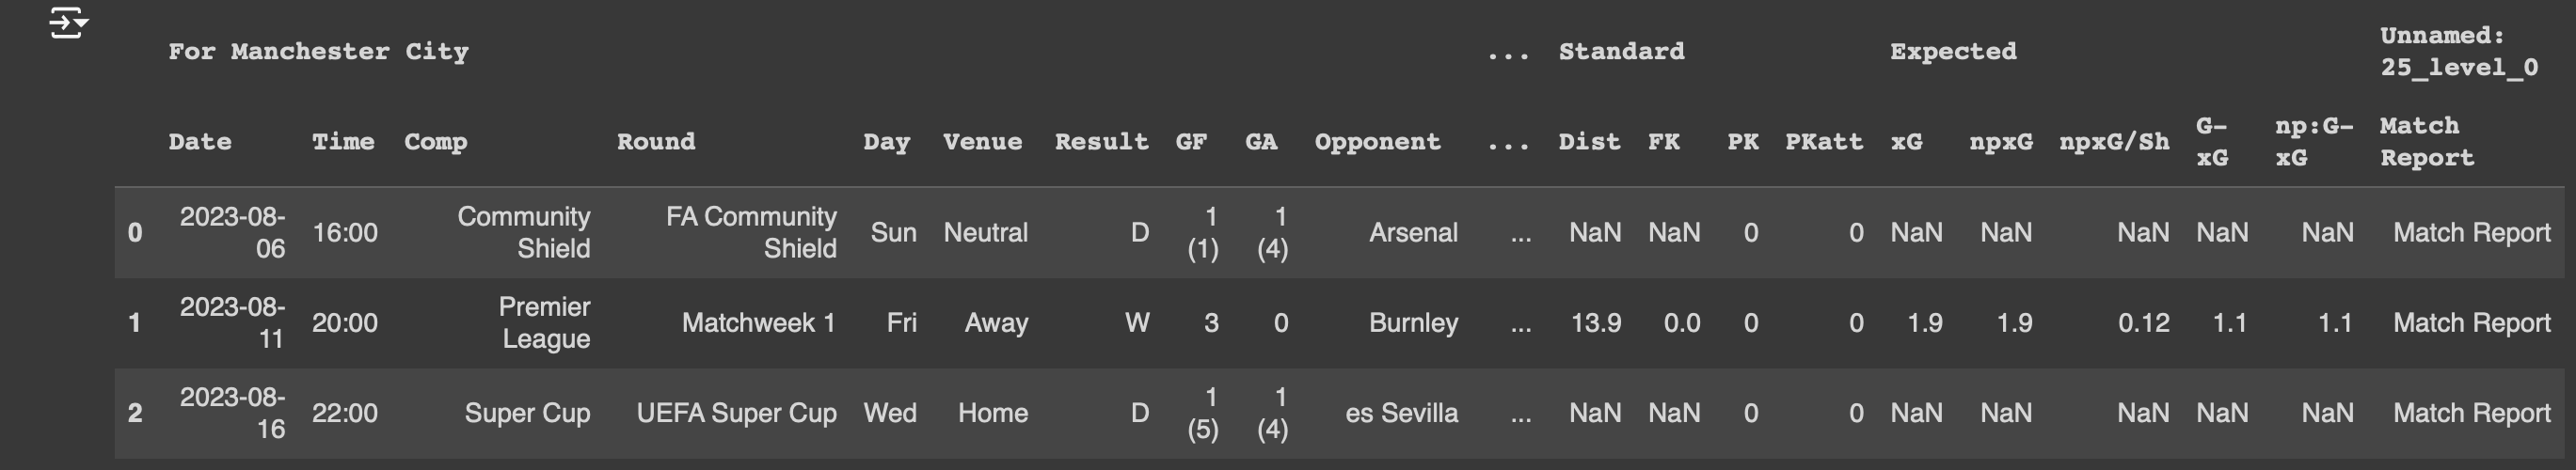

In [44]:
shooting = pd.read_html(data.text, match="Shooting")[0]

Now we have to drop an index level because it is currently  a multi-level index. We can do this by using 'droplevel()'

In [45]:
shooting.columns = shooting.columns.droplevel()

Now we will combine both the 'matches' and 'shooting' DataFrame using the pandas 'merge' method. We were merge the columns that aren't duplicated. We will merge the DataFrames on the 'Date' column

In [46]:
team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")

Now that we have a DataFrame for a single team that has both matches and shooting stats. We will have to create a for loop for multiple teams and years.



1. First we will start off by setting a varible called 'years' equal to the years we will scrape for. I decided to choose seasons between 2024 and 2017
2. Then we intialize a list called 'all_matches' that will hold several data frames, each will contain match logs for one team in one season



In [58]:
years = list(range(2024,2019, -1))
all_matches = []

Now we will define the url we want to start on which is the main page for the Premier League stats of the current year (2024)

In [59]:
standings_url = "https://fbref.com/en/comps/9/Premier-League-Stats"

Now we will create our loop and use previous code we have devloped

In [60]:
import time
for year in years:

  #Getting the HTML for the stats_table
  data = requests.get(standings_url)
  soup = BeautifulSoup(data.text)
  standings_table = soup.select('table.stats_table')[0]

  #Getting the squad absolute URL from the HTML
  links = [l.get('href') for l in standings_table.find_all('a')]
  links = [l for l in links if '/squads/' in l]
  team_urls = [f"https://fbref.com{l}" for l in links]

  #Getting URL for previous season
  previous_season = soup.select("a.prev")[0].get("href")
  standings_url = f"https://fbref.com{previous_season}"

  for team_url in team_urls:
    #Getting the team name and formatting it
    team_name = team_url.split("/")[-1].replace("-Stats", "").replace("-", " ")

    #Getting the HTML for the team page and turning it into a DataFrame
    data = requests.get(team_url)
    matches = pd.read_html(data.text, match="Scores & Fixtures")[0]

    #Getting the Shooting DataFrame for the specific team
    soup = BeautifulSoup(data.text)
    links = [l.get('href') for l in soup.find_all('a')]
    links = [l for l in links if l and 'all_comps/shooting/' in l]
    data = requests.get(f"https://fbref.com{links[0]}")
    shooting = pd.read_html(data.text, match="Shooting")[0]
    shooting.columns = shooting.columns.droplevel()

    #Trying to merge the DataFrames but some might not having shooting stats so we put an exception error
    try:
      team_data = matches.merge(shooting[["Date", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]], on="Date")
    except ValueError:
      continue

    #Only collecting data from Premier Leauge matches
    team_data = team_data[team_data["Comp"] == "Premier League"]

    #Adding Season and Team columns
    team_data["Season"] = year
    team_data["Team"] = team_name
    all_matches.append(team_data)

    #Pause the loop for 10 seconds so we dont get blacked
    time.sleep(10)

In [61]:
#combine all the dataframes into a single date frame
match_df = pd.concat(all_matches)

#making all columns lowercase
match_df.columns = [c.lower() for c in match_df.columns]


In [63]:
#Writing to CSV
match_df.to_csv("pl_stats.csv")